# Chapter 4 - Policy Gradient Methods

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [3]:
env = gym.make("CartPole-v0")

In [4]:
state1 = env.reset()  # 환경 초기화 
action = env.action_space.sample()  # 무작위 동작 중 하나 추출 
# done: 막대가 쓰러지거나 카트가 창 바깥으로 나가면 true 
# info: 디버깅에 유용한 진단 정보를 담은 dictionary 객체 
state, reward, done, info = env.step(action)

In [6]:
print("state:",state)
print("reward:", reward)
print("done:",done)
print("info:", info)

state: [ 0.01806318  0.19029523  0.03676527 -0.28828296]
reward: 1.0
done: False
info: {}


##### Listing 4.4

In [7]:
import gym
import numpy as np
import torch

l1 = 4 #  state는 4개의 성분을 가짐 
l2 = 150
l3 = 2 # left and right 

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) # action들에 대한 확률 분포 산출 
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#A Input data is length 4
#B Output is a 2-length vector for the Left and the Right actions
#C Output is a softmax probability distribution over actions

##### Listing 4.5

In [8]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) # policy net으로 action 확률 예측
# 예측한 확률에 따라 action 추출 
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state2, reward, done, info = env.step(action) #I

#G Call policy network model to produce predicted action probabilities
#H Sample an action from the probability distribution produced by the policy network
#I Take the action, receive new state and reward. The info variable is produced by the environment but is irrelevant

##### Listing 4.6

In [9]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    # 최근일수록 더 많이 discount 됨 
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #A
    disc_return /= disc_return.max() #B 정규화, 학습의 안정성에 도움이 됨 
    return disc_return

#A Compute exponentially decaying rewards
#B Normalize the rewards to be within the [0,1] interval to improve numerical stability

##### Listing 4.7

In [10]:
def loss_fn(preds, r): #A 확률들과 discount된 보상들을 받음 
    # loss = discount_rewards * log prob
    return -1 * torch.sum(r * torch.log(preds)) #B

#A The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
#B It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.

##### Listing 4.8

In [19]:
MAX_DUR = 300
MAX_EPISODES = 500
gamma = 0.99
score = [] #A
# expectation = 0.0  # only in code, not in book 
for episode in range(MAX_EPISODES):

    # 환경 초기화 
    curr_state = env.reset()
    done = False
    transitions = [] #B (state, action, reward)
    
    for t in range(MAX_DUR): #C
        # policy net으로 action 확률 얻기
        act_prob = model(torch.from_numpy(curr_state).float()) #D 
        # 확률을 이용해서 action 선택 
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        # 상태 업데이트 
        prev_state = curr_state
        # 뽑은 action으로 한 step 실행 
        curr_state, _, done, info = env.step(action) #F
        # (state, aciton, reward) 저장 ???: 왜 reward가 t+1이지? 
        transitions.append((prev_state, action, t+1)) #G
        if done: #H 실패하면 나가기 
            break

    ep_len = len(transitions) #I transition의 길이가 episode 길이 
    score.append(ep_len)  # 오래 버티는만큼 점수이므로 길이가 점수와 같다 
    # reward 다 받아서 뒤집기
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    # print(reward_batch) 
    disc_returns = discount_rewards(reward_batch) #K
    
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    
    pred_batch = model(state_batch) #N
    # 실제로 한 동작들만 모으기 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#A List to keep track of the episode length over training time
#B List of state, action, rewards (but we ignore the reward)
#C While in episode
#D Get the action probabilities
#E Select an action stochastically
#F Take the action in the environment
#G Store this transition
#H If game is lost, break out of the loop
#I Store the episode length
#J Collect all the rewards in the episode in a single tensor
#K Compute the discounted version of the rewards
#L Collect the states in the episode in a single tensor
#M Collect the actions in the episode in a single tensor
#N Re-compute the action probabilities for all the states in the episode
#O Subset the action-probabilities associated with the actions that were actually taken 

In [20]:
score = np.array(score)
avg_score = running_mean(score, 50)

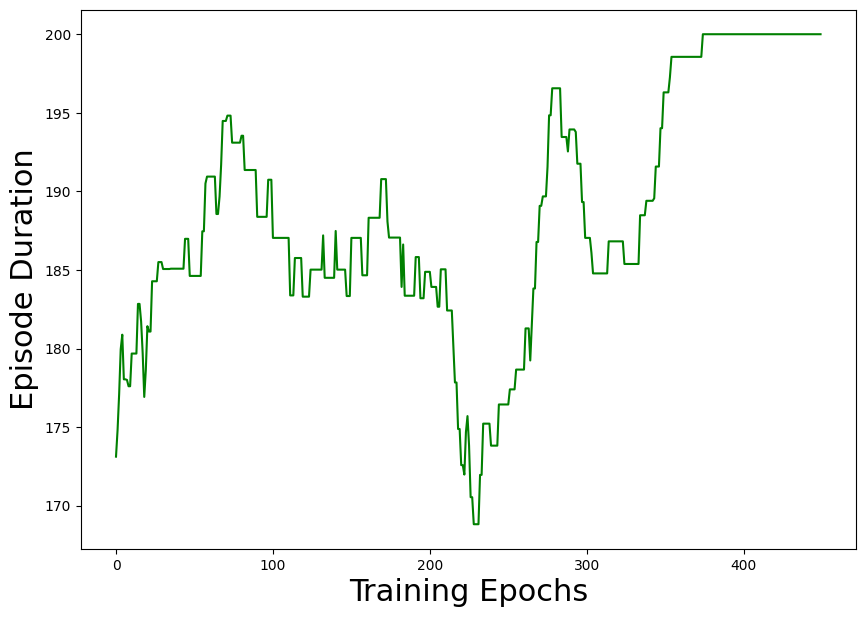

In [21]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

##### Listing 4.9

In [24]:
# 200 step 이상이면 성공으로 간주한다. 얼마나 성공적인지 plot을 하는 코드 
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float()) #G
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
        state2, reward, done, info = env.step(action) #I
        state1 = state2 
        t += 1
        if t > MAX_DUR: #L
            break;
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

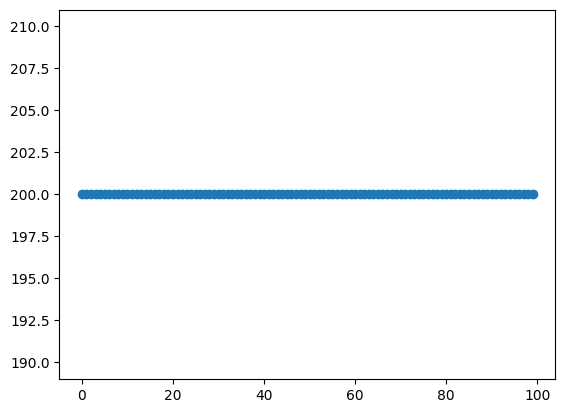

In [25]:
plt.scatter(np.arange(score.shape[0]),score)